# Modelo de Machine Learning

David Alejandro Pedroza De Jesús
Joel Ezequiel Vicente Alonso

In [42]:

import matplotlib.pyplot as plt
from skimage.feature import hog
import numpy as np
import pandas as pd
import cv2
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import os
import kagglehub
from shutil import move
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
import seaborn as sns
from sklearn.metrics import log_loss
from sklearn.metrics import ConfusionMatrixDisplay
import joblib

In [43]:
path = kagglehub.dataset_download("gpiosenka/cards-image-datasetclassification")
#move(path,os.getcwd())
#os.rename("2", "cards-image-datasetclassification")



Using Colab cache for faster access to the 'cards-image-datasetclassification' dataset.


In [44]:
datos = pd.read_csv(r"cards-image-datasetclassification/cards.csv")
datos.head(2000)

,class index,filepaths,labels,card type,data set
0,0,train/ace of clubs/001.jpg,ace of clubs,ace,train
1,0,train/ace of clubs/002.jpg,ace of clubs,ace,train
2,0,train/ace of clubs/003.jpg,ace of clubs,ace,train
3,0,train/ace of clubs/004.jpg,ace of clubs,ace,train
4,0,train/ace of clubs/005.jpg,ace of clubs,ace,train
...,...,...,...,...,...
1995,13,train/four of diamonds/071.jpg,four of diamonds,four,train
1996,13,train/four of diamonds/072.jpg,four of diamonds,four,train
1997,13,train/four of diamonds/073.jpg,four of diamonds,four,train
1998,13,train/four of diamonds/074.jpg,four of diamonds,four,train


In [45]:
rutas_adaptadas = ["cards-image-datasetclassification/" +  ruta for ruta in datos["filepaths"]]
im_buenas = []
im_malas = []
for ru in rutas_adaptadas:
    im = cv2.imread(ru)
    if  im is not None:
        im_buenas.append(ru)
    else:
        im_malas.append(ru)
print(f"Lecturas correctas: {len(im_buenas)}")
print(f"Lecturas incorrectas: {len(im_malas)}")

df_limpio = datos[np.array(rutas_adaptadas) != np.array(im_malas)]
df_limpio["rutas_adap"] = im_buenas

Lecturas correctas: 8154
Lecturas incorrectas: 1


/tmp/ipython-input-2107/4150467203.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_limpio["rutas_adap"] = im_buenas


In [46]:
def features_extract(path):
  img = cv2.imread(path)
  img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  features = hog(img_gray,
                 pixels_per_cell=(8,8),
                 cells_per_block=(2,2),
                 feature_vector=True)
  return features

In [47]:


rutas_train = df_limpio[df_limpio["data set"] == "train"].rutas_adap
rutas_test = df_limpio[df_limpio["data set"] == "test"].rutas_adap
rutas_val = df_limpio[df_limpio["data set"] == "valid"].rutas_adap

X_train = np.array([features_extract(p) for p in rutas_train])
X_test = np.array([features_extract(p) for p in rutas_test])
X_val = np.array([features_extract(p) for p in rutas_val])


y_train = df_limpio[df_limpio["data set"] == "train"]["labels"]
y_test = df_limpio[df_limpio["data set"] == "test"]["labels"]
y_val = df_limpio[df_limpio["data set"] == "valid"]["labels"]



In [48]:
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)
X_val_norm = scaler.transform(X_val)

In [49]:


encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train.values.reshape(-1,1))
y_test_enc = encoder.transform(y_test.values.reshape(-1,1))
y_val_enc = encoder.transform(y_val.values.reshape(-1,1))



/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
import matplotlib.pyplot as plt
import seaborn as sns

Xtr, Xva, Xte = X_train_norm, X_val_norm, X_test_norm
ytr, yva, yte = y_train_enc.ravel(), y_val_enc.ravel(), y_test_enc.ravel()

model = RandomForestClassifier(
    n_estimators=500,
    max_depth=40,
    min_samples_split=4,
    min_samples_leaf=5,
    n_jobs=-1,
    random_state=42
)

model.fit(Xtr, ytr)

RandomForestClassifier(max_depth=40, min_samples_leaf=5, min_samples_split=4,
                       n_estimators=500, n_jobs=-1, random_state=42)

In [51]:
y_train_prob = model.predict_proba(Xtr)
y_val_prob   = model.predict_proba(Xva)
y_test_prob  = model.predict_proba(Xte)

train_loss = log_loss(ytr, y_train_prob)
val_loss   = log_loss(yva, y_val_prob)
test_loss  = log_loss(yte, y_test_prob)

train_acc = accuracy_score(ytr, model.predict(Xtr))
val_acc   = accuracy_score(yva, model.predict(Xva))
test_acc  = accuracy_score(yte, model.predict(Xte))

print(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f}")
print(f"Val   loss: {val_loss:.4f} | Val   acc: {val_acc:.4f}")
print(f"Test  loss: {test_loss:.4f} | Test  acc: {test_acc:.4f}")

Train loss: 1.1745 | Train acc: 0.9982
Val   loss: 2.5337 | Val   acc: 0.5698
Test  loss: 2.5451 | Test  acc: 0.5811


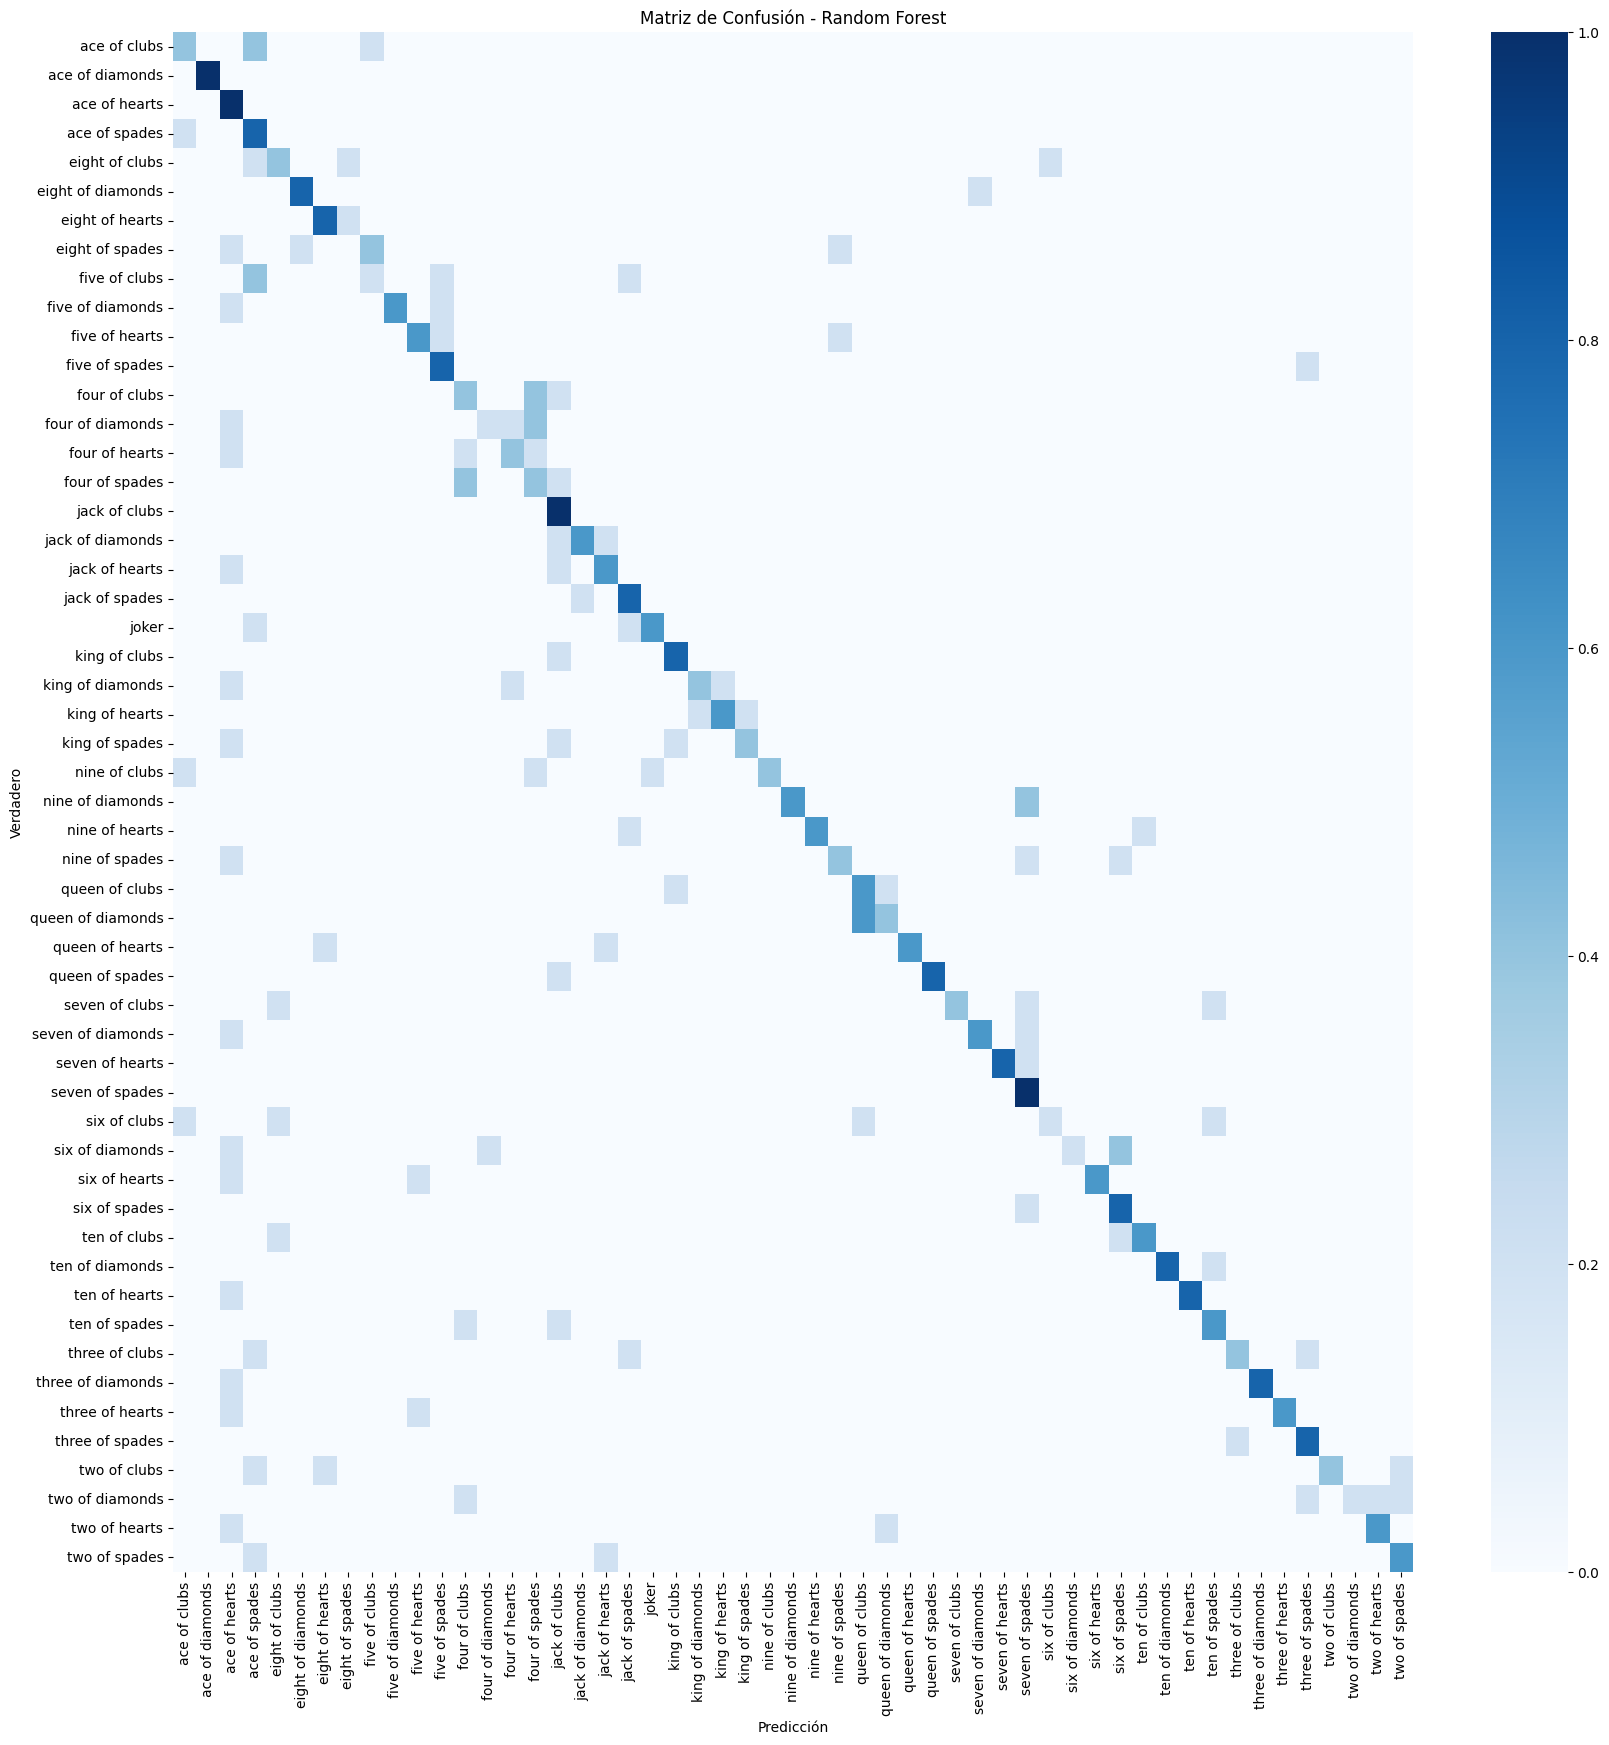

In [52]:
cm = confusion_matrix(yte, model.predict(Xte), normalize="true")

plt.figure(figsize=(20,20))
sns.heatmap(
    cm, annot=False, cmap="Blues",
    xticklabels=encoder.classes_,
    yticklabels=encoder.classes_,
    cbar=True
)
plt.xlabel("Predicción")
plt.ylabel("Verdadero")
plt.title("Matriz de Confusión - Random Forest")
plt.yticks(rotation=0)
plt.show()

In [53]:
# guardar el modelo

joblib.dump(model, "modelo_random_forest.pkl")

['modelo_random_forest.pkl']

In [54]:
total_leaves = sum(t.tree_.n_leaves for t in model.estimators_)
print("Total leaves:", total_leaves)

Total leaves: 368901


# Conclusión

A pesar de intentar diferentes combinaciones de hiperparametros, el modelo muestra demasiado overfitting y no es capaz de predecir correctamente las clases de las fotos